In [84]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sys

# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = [4, 4]
plt.style.use('ggplot')

In [85]:
# returns {'name': ([ratios], [throughputs])}
def to_dict(names, ratios, through_comp, through_decomp):
    res = {}
    for i, n in enumerate(names):
        if not n in res: res[n] = ([], [], [])
        res[n][0].append(ratios[i])
        res[n][1].append(through_comp[i])
        res[n][2].append(through_decomp[i])
    return res

def extract_lzbench(csv):
    results = pd.read_csv(open(csv, 'rb'))
    # first line is memcpy
    results = results[1:]
    names = [x.split()[0] for x in results['Compressor name']]
    ratios = list(results['Ratio']/100)
    through_comp = list(results['Compression speed'])
    through_decomp = list(results['Decompression speed'])
    return to_dict(names, ratios, through_comp, through_decomp)

def extract_nvcomp(csv):
    results = pd.read_csv(open(csv, 'rb'))
    results = results[1:]
    names = list(results['Compressor name'])
    ratios = list(1/results['Compression ratio'])
    through_comp = list(1000*results['Compression throughput (uncompressed) in GB/s'])
    through_decomp = list(1000*results['Decompression throughput (uncompressed) in GB/s'])
    return to_dict(names, ratios, through_comp, through_decomp)

def plot(results, color=None, label=None):
    for name in results:
        res = results[name]
        
        gpu = name in ['dietgpu', 'bsc_cuda', 'nvcomp_lz4',
                       'hcmc', 'culzss', 'cuda_bzip2']
        gpu = gpu or 'nvcomp' in name
        nx = name == 'libnxz'
        
        alpha = 1 if gpu or nx else 0.6
        marker =  '' if len(res[0]) > 1 else '.'
        if 'bsc_cuda' in name: name = 'bsc'
        if gpu: name = name + '*'
        if nx: name = name + '**'
        name = ' ' + name
        
        plt.plot(res[0], res[1], marker=marker, markersize=4, color=color, label=label, alpha=alpha)
#         plt.plot(res[0], res[2], marker=marker, markersize=3, color=color, label=label, alpha=alpha)
        plt.annotate(name, (res[0][0], res[1][0]), fontsize=9, alpha=alpha)
#         plt.annotate(name+'_d', (res[0][0], res[2][0]), fontsize=9, alpha=alpha)
        plt.xlabel('Compression ratio (outsize/insize)')
        plt.ylabel('Throughput (MB/s)')
        plt.yscale('log')
        plt.subplots_adjust(left=0.2, right=0.75)
    
def plotterino(fnames, colors, outname=None):
    for fname, color in zip(fnames, colors):
        if 'nvcomp' in fname:
            res = extract_nvcomp(fname)
        else:
            res = extract_lzbench(fname)
            res.pop('lzma')
            res.pop('bsc')
    #         res.pop('xz')
    #         res.pop('zlib')
            label = 'POWER9' if 'p9' in fname else 'HLT-like'
        plot(res, color, label)
        
    legend = plt.legend(bbox_to_anchor=(1.05, 0.6), loc="upper left")
    frame = legend.get_frame()
#     frame.set_facecolor('white')
    frame.set_edgecolor('white')
    if outname:
        plt.savefig(outname, dpi=300)
    else:
        plt.show()

In [86]:
fnames_pp = [
    'results/p9-pp.csv',
    'results/hlt-pp.csv',
#     'results/old/nvcomp.csv',
    ]
fnames_hi = [
    'results/p9-hi.csv',
    'results/hlt-hi.csv',
    ]
cmap = matplotlib.cm.get_cmap('inferno')
colors = [cmap(0.3), cmap(0.5), cmap(0.5), cmap(0.6)]
colors_pp = colors
colors_hi = colors[2:]

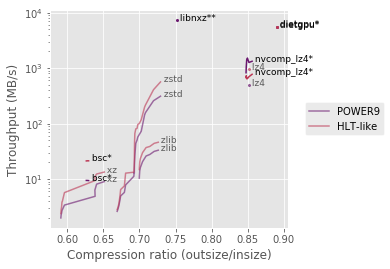

In [87]:
plotterino(fnames_pp, colors_pp, 'results/combined-pp.png')

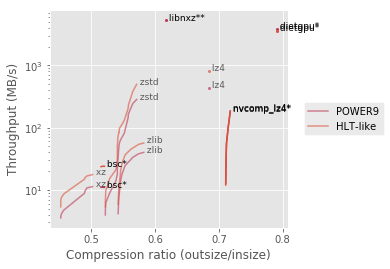

In [88]:
plotterino(fnames_hi, colors_hi, 'results/combined-hi.png')

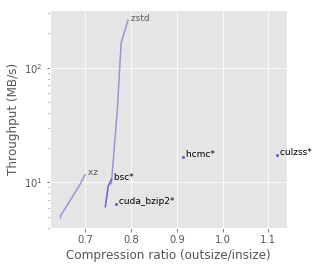

In [102]:
cres = {'zstd': [['-1', '-3', '-9', '-19'], [258.4140463296379, 163.88852924781074, 43.72637526427399, 9.687707828359505], [0.7933601455488924, 0.7782279396745265, 0.7702009160626969, 0.756965973429537]], 'xz': [['-0', '-3', '-6', '-9'], [11.606166096022688, 9.458649823623368, 5.100490349702948, 4.885381564136004], [0.6994451579373356, 0.6877364378594628, 0.646091372563434, 0.646091372563434]], 'bsc_cuda': [['-G -m5 -e0', '-G -m5 -e1', '-G -m5 -e2'], [10.621215693845622, 9.186427734113185, 6.122815660623057], [0.7569990726725884, 0.7499531398838015, 0.743792291826334]], 'culzss': [[''], [17.34874110339761], [1.1181232253731117]], 'hcmc': [[''], [16.585734771547497], [0.9126902314990318]], 'cuda_bzip2': [[''], [6.499193246661601], [0.766410046955208]]}
for n in cres:
    r = cres[n]
    cres[n] = [r[2], r[1]]
    
# plot(cruderes, color=cmap(0.4))
plot(cruderes, color='slateblue')
plt.savefig('results/first.png', dpi=300)